<a href="https://colab.research.google.com/github/sjoshi4may/Generative_AI/blob/main/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
## Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [70]:
def preprocess(images):
    images = images.astype("float32")/255.0
    images = np.expand_dims(images,-1)
    return images

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [71]:
# Run if you only want to constrain on training digit 8 images
x_train = x_train[y_train==8]
y_train = y_train[y_train==8]


In [72]:
x_train_pca = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
x_test_pca = x_test.reshape((x_test.shape[0], x_test.shape[1]*x_test.shape[2]))

## PCA

In [73]:
from sklearn.decomposition import PCA

In [74]:
pca = PCA(n_components=32)

In [75]:
pca.fit(x_train_pca)

PCA(n_components=32)

In [76]:
print(pca.explained_variance_ratio_)

[0.12355624 0.07671897 0.06503263 0.05661383 0.03983114 0.03203372
 0.02796066 0.02567692 0.024638   0.02172162 0.02081783 0.02059781
 0.01924527 0.01626735 0.01557798 0.01537429 0.01432035 0.01318387
 0.01243911 0.01137359 0.010527   0.00998317 0.00914191 0.00876086
 0.00856243 0.0084132  0.00774897 0.00766554 0.00707996 0.00695579
 0.00665085 0.00615273]


In [77]:
n = 5000
samples = x_test_pca[:n]
y_samples = y_test[:n]
preds = pca.inverse_transform(pca.transform(samples))

In [78]:
preds = preds.reshape((n,28,28,1))
samples = samples.reshape((n,28,28,1))

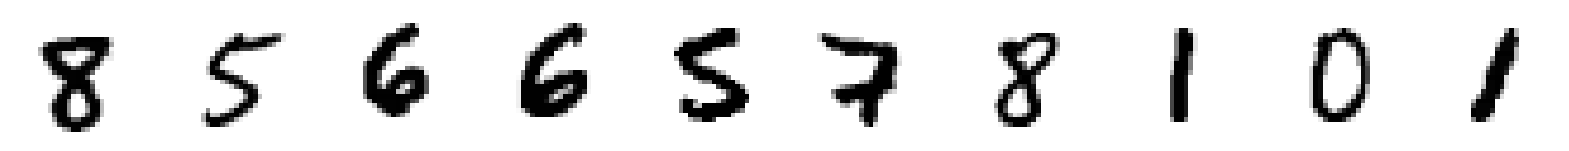

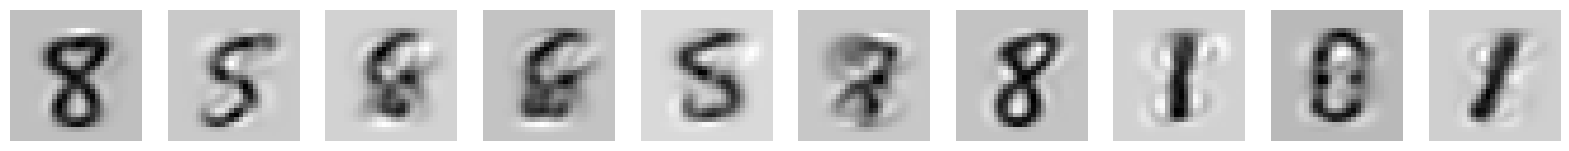

In [79]:
plt.figure(figsize=[20,3])
for i in range(10):
    _ = plt.subplot(1,10,i+1)
    plt.imshow(samples[i+128].astype("float32"),cmap="gray_r")
    plt.axis("off")

plt.figure(figsize=[20,3])
for i in range(10):
    _ = plt.subplot(1,10,i+1,)
    plt.imshow(preds[i+128].astype("float32"),cmap="gray_r")
    plt.axis("off")

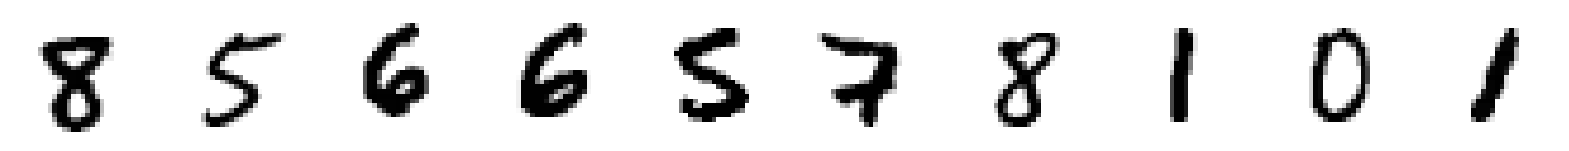

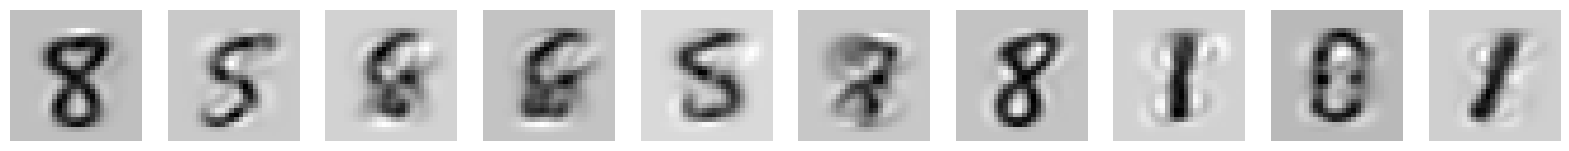

In [80]:
plt.figure(figsize=[20,3])
for i in range(10):
    _ = plt.subplot(1,10,i+1)
    plt.imshow(samples[i+128].astype("float32"),cmap="gray_r")
    plt.axis("off")

plt.figure(figsize=[20,3])
for i in range(10):
    _ = plt.subplot(1,10,i+1,)
    plt.imshow(preds[i+128].astype("float32"),cmap="gray_r")
    plt.axis("off")

In [81]:
# 1. So for 8, PCA is quite good but for other digits it's not.
# 2. It's horrible at fashion-mnist

In [82]:
preds.shape

(5000, 28, 28, 1)

## Autoencoder

In [103]:
IMAGE_SHAPE = x_train.shape[1:]
EPOCHS = 10
BATCH_SIZE=64
EMBEDDING_DIM=32
CHANNELS = x_train.shape[-1]

In [104]:
# Encoder
encoder_input = layers.Input(shape=IMAGE_SHAPE, name="encoder_input")
x = layers.Conv2D(32, (3,3), strides=1, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3,3), strides=1, activation="relu", padding="same")(x)
shape_before_flat = K.int_shape(x)[1:]
x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM,name="encoder_output")(x)
encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 flatten_6 (Flatten)         (None, 50176)             0         
                                                                 
 encoder_output (Dense)      (None, 32)                1605664   
                                                                 
Total params: 1,624,480
Trainable params: 1,624,480
Non-trainable params: 0
_________________________________________________________________


In [105]:
# Decoder
decoder_input = layers.Input(shape = (EMBEDDING_DIM,), name = "decoder_input")
x = layers.Dense(np.prod(shape_before_flat))(decoder_input)
x = layers.Reshape(shape_before_flat)(x)
x = layers.Conv2DTranspose(32, (3,3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides=1, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(CHANNELS, (3,3), strides=1, activation="relu", padding="same")(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 32)]              0         
                                                                 
 dense_6 (Dense)             (None, 50176)             1655808   
                                                                 
 reshape_6 (Reshape)         (None, 28, 28, 64)        0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 64)       18496     
 ranspose)                                                       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 1)         577

In [106]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.compile(loss="mse", optimizer="adam")

In [107]:
autoencoder.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 flatten_6 (Flatten)         (None, 50176)             0         
                                                                 
 encoder_output (Dense)      (None, 32)                1605664   
                                                                 
 model_15 (Functional)       (None, 28, 28, 1)         1693345   
                                                                 
Total params: 3,317,825
Trainable params: 3,317,825
Non-tr

In [108]:
autoencoder.fit(x_train,
                x_train,
                epochs = EPOCHS,
                batch_size = BATCH_SIZE,
                validation_data = (x_test, x_test))

Epoch 1/10
92/92 [==============================] - 5s 29ms/step - loss: 0.0423 - val_loss: 0.0400
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 0.0142 - val_loss: 0.0242
Epoch 3/10
92/92 [==============================] - 2s 21ms/step - loss: 0.0085 - val_loss: 0.0184
Epoch 4/10
92/92 [==============================] - 2s 26ms/step - loss: 0.0066 - val_loss: 0.0151
Epoch 5/10
92/92 [==============================] - 2s 23ms/step - loss: 0.0056 - val_loss: 0.0139
Epoch 6/10
92/92 [==============================] - 2s 26ms/step - loss: 0.0049 - val_loss: 0.0127
Epoch 7/10
92/92 [==============================] - 2s 22ms/step - loss: 0.0045 - val_loss: 0.0127
Epoch 8/10
92/92 [==============================] - 2s 20ms/step - loss: 0.0043 - val_loss: 0.0120
Epoch 9/10
92/92 [==============================] - 2s 26ms/step - loss: 0.0038 - val_loss: 0.0119
Epoch 10/10
92/92 [==============================] - 2s 26ms/step - loss: 0.0036 - val_loss: 0.0120


In [109]:
n = 5000
samples = x_test[:n]
y_samples = y_test[:n]
preds = autoencoder.predict(samples)
sample_encoding = encoder(samples)

157/157 [==============================] - 1s 3ms/step


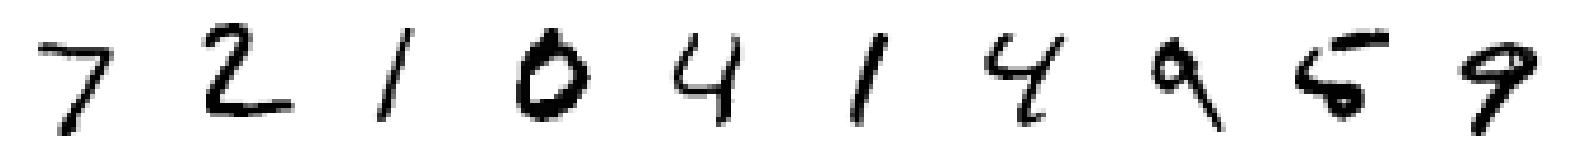

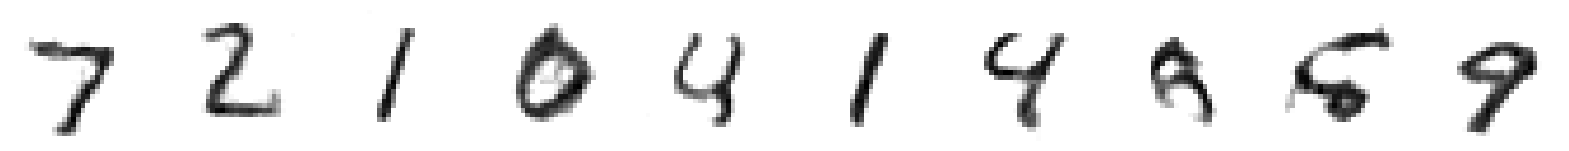

In [110]:
plt.figure(figsize=[20,3])
for i in range(10):
    _ = plt.subplot(1,10,i+1)
    plt.imshow(samples[i].astype("float32"),cmap="gray_r")
    plt.axis("off")

plt.figure(figsize=[20,3])
for i in range(10):
    _ = plt.subplot(1,10,i+1,)
    plt.imshow(preds[i].astype("float32"),cmap="gray_r")
    plt.axis("off")

In [112]:
## Show t-SNE clusters

In [113]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

In [114]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(sample_encoding)

In [115]:
X_embedded[y_samples==3].shape

(500, 2)

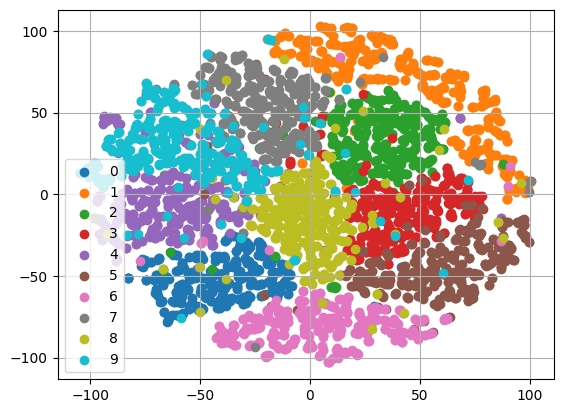

In [116]:
fig, ax = plt.subplots()
for i, color in enumerate(mcolors.TABLEAU_COLORS):
    x,y = X_embedded[y_samples==i][:,0], X_embedded[y_samples==i][:,1]
    ax.scatter(x, y, c=color, label=i)

ax.legend()
ax.grid(True)

In [117]:
## Generative examples : random samples
mins, maxs = np.min(sample_encoding, axis=0), np.max(sample_encoding, axis=0)
sample = np.random.uniform(mins, maxs, size=(10, EMBEDDING_DIM))
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 87ms/step


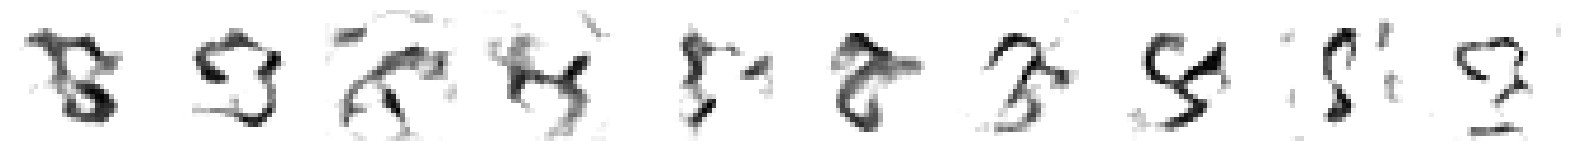

In [118]:
plt.figure(figsize=[20,3])
for i in range(10):
    _ = plt.subplot(1,10,i+1)
    plt.imshow(reconstructions[i].astype("float32"),cmap="gray_r")
    plt.axis("off")

In [119]:
## Basically, the reconstructions of input images are good but random samples are bad. There is gap in the latent space due to single image mapping to single image i,e
## point to point mapping in autoecoders, therefore any nearby point is not guaranteed to proivde a sensible generation.
## Therefore, autoencoders are good lossy compression algorithms but bad generative algorithms due to discontinuous latent space leading to noisy generations.

### To convert Autoencoders to be a good generative solution, we need to look at variational auto-encoders.

In [120]:
## Morphing
sample_encoding[0], y_samples[0]

(<tf.Tensor: shape=(32,), dtype=float32, numpy=
 array([ 0.32867044, -0.6944951 ,  0.4915789 , -1.500539  , -0.46210447,
         0.6262873 ,  1.1995472 ,  1.6336797 , -1.9764037 , -0.75908536,
        -0.5925708 , -0.41991773, -1.1411171 , -0.6600575 ,  0.7630647 ,
         0.85058576, -0.11552578, -0.68449056,  0.91060585, -0.13719153,
         0.92425805, -1.5148433 ,  0.38258278, -0.60864323, -0.6415571 ,
        -0.41510162,  1.2153647 , -0.796972  ,  0.49649295,  0.05527198,
         0.50525045, -0.04649961], dtype=float32)>,
 7)

In [121]:
sample_encoding[1], y_samples[1]

(<tf.Tensor: shape=(32,), dtype=float32, numpy=
 array([ 0.3419161 , -1.0261633 , -0.48222575, -0.42898673, -0.2728149 ,
        -1.1849838 , -1.046067  , -1.8123723 , -0.20374067, -0.8248893 ,
         1.0280389 ,  0.15711382,  1.7072386 ,  1.3106956 , -2.1575491 ,
         0.05757973,  1.2097669 , -0.73089075,  0.12661032,  0.1681822 ,
         0.04494436,  1.5142843 ,  0.23742239,  1.1394913 ,  1.097226  ,
        -0.32112363,  0.12789442, -0.13755423,  1.2460722 ,  1.2068095 ,
         0.37180474,  0.10558578], dtype=float32)>,
 2)

In [122]:
alpha = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
res = []
for val in alpha:
    enc = tf.scalar_mul(1-val, sample_encoding[120]) + tf.scalar_mul(val, sample_encoding[185])
    reconstruction = tf.reshape(decoder(tf.reshape(enc, (1,EMBEDDING_DIM))),IMAGE_SHAPE)
    res.append(reconstruction)


In [123]:
res[0].shape

TensorShape([28, 28, 1])

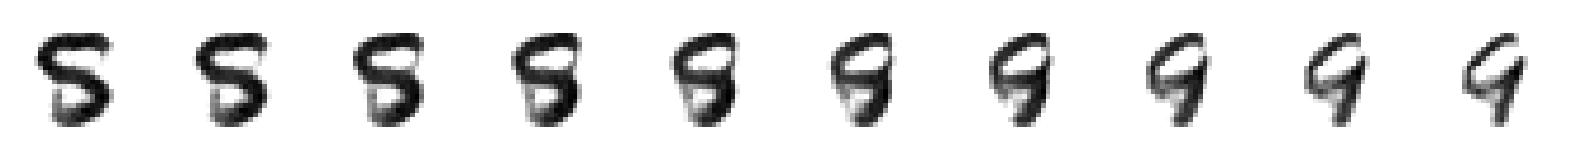

In [124]:
plt.figure(figsize=[20,3])
for i in range(10):
    _ = plt.subplot(1,10,i+1)
    plt.imshow(res[i],cmap="gray_r")
    plt.axis("off")